<a href="https://colab.research.google.com/github/whythoSanskar/car_damage/blob/main/Project_Hackthon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Importing Required Libraries**

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import MaxPooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **2. Dataset Paths and Basic Statistics**

In [ ]:
# Path to directory containing data
DataDir = "/content/drive/MyDrive/data1a"
train_dir = os.path.join(DataDir, 'training/')
val_dir = os.path.join(DataDir, 'validation/')

In [ ]:
# Paths for damaged and not-damaged images
train_damage = os.path.join(train_dir, '00-damage')
train_not_damage = os.path.join(train_dir, '01-whole')
val_damage = os.path.join(val_dir, '00-damage')
val_not_damage = os.path.join(val_dir, '01-whole')

In [ ]:
# Count images
num_train_damage = len(os.listdir(train_damage))
num_train_not_damage = len(os.listdir(train_not_damage))
num_val_damage = len(os.listdir(val_damage))
num_val_not_damage = len(os.listdir(val_not_damage))

num_train = num_train_damage + num_train_not_damage
num_val = num_val_damage + num_val_not_damage
total_images = num_train + num_val

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/data1a/training/00-damage'

In [ ]:
# Print statistics
print("Total training images:", num_train)
print("Total training images (Damaged):", num_train_damage)
print("Total training images (Not Damaged):", num_train_not_damage)
print()
print("Total validation images:", num_val)
print("Total validation images (Damaged):", num_val_damage)
print("Total validation images (Not Damaged):", num_val_not_damage)
print()
print("Total Number of Images:", total_images)

Total training images: 1840
Total training images (Damaged): 920
Total training images (Not Damaged): 920

Total validation images: 460
Total validation images (Damaged): 230
Total validation images (Not Damaged): 230

Total Number of Images: 2300


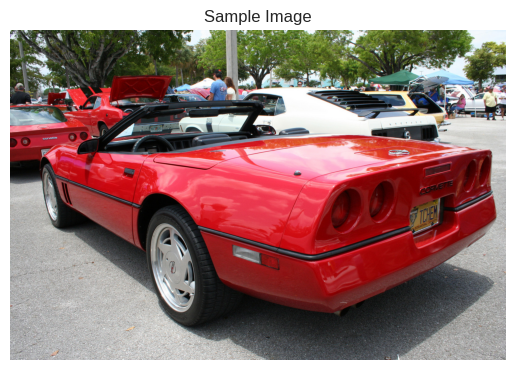

In [ ]:
# Plotting a sample image
image = plt.imread('/content/drive/MyDrive/data1a/training/01-whole/0200.jpg')
plt.grid(False)
plt.imshow(image)
plt.title("Sample Image")
plt.axis('off')
plt.show()

# **3. Hyperparameters**

In [ ]:
# Initializing the hyperparameters
initial_lr = 0.001
epochs = 10
batch_size = 64
classes = ["00-damage", "01-whole"]

# **4. Data Preprocessing**

In [ ]:
# Load images and preprocess them
print("[INFO] Loading images...")

data = []
labels = []

# Process training and validation directories
for class_ in classes:
    for sub_dir in [train_dir, val_dir]:
        path = os.path.join(sub_dir, class_)
        for image in os.listdir(path):
            image_path = os.path.join(path, image)
            image_ = load_img(image_path, target_size=(224, 224))
            image_ = img_to_array(image_)
            image_ = preprocess_input(image_)
            data.append(image_)
            labels.append(class_)

# Perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)

# Train-test split
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state=42)

# Data augmentation
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")


[INFO] Loading images...


# **5. Building the Model**

In [ ]:
# Load the MobileNetV2 network, excluding the top fully connected layers
model_base = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# Construct the top layers
model_head = model_base.output
model_head = MaxPooling2D(pool_size=(5, 5))(model_head)
model_head = Flatten(name="flatten")(model_head)
model_head = Dense(128, activation="relu")(model_head)
model_head = Dropout(0.5)(model_head)
model_head = Dense(2, activation="softmax")(model_head)

# Combine base and top layers into the final model
model_final = Model(inputs=model_base.input, outputs=model_head)

# Freeze base model layers
for layer in model_base.layers:
    layer.trainable = False


<ipython-input-50-03dba5809181>:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  model_base = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))


# **6. Compiling the Model**

In [ ]:
# Setting optimizer to Adam
optim = Adam(learning_rate=initial_lr)

# Compiling the model
model_final.compile(loss="binary_crossentropy", optimizer=optim, metrics=["accuracy"])

# **7. Training the Model**

In [ ]:
# Train the model
model_train = model_final.fit(
    aug.flow(trainX, trainY, batch_size=batch_size),
    steps_per_epoch=len(trainX) // batch_size,
    validation_data=(testX, testY),
    validation_steps=len(testX) // batch_size,
    epochs=100)

Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 158s 5s/step - accuracy: 0.7871 - loss: 0.4658 - val_accuracy: 0.8435 - val_loss: 0.3485
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8750 - loss: 0.3641 
Epoch 3/100


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


18/28 ━━━━━━━━━━━━━━━━━━━━ 44s 4s/step - accuracy: 0.8395 - loss: 0.4130

# **8. Evaluation and Saving the Model**

In [ ]:
# Now, we predict on test set.
predict = model_final.predict(testX, batch_size=batch_size)

# for each image in the test set we find the index of the
# label with corresponding largest predicted probability
predict_index = np.argmax(predict, axis=1)

# Displaying classification report
print(classification_report(testY.argmax(axis=1), predict_index,
	target_names=lb.classes_))

# Storing our model for further use.
model_final.save("/content/Car_detection.model100.h5")


8/8 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step


              precision    recall  f1-score   support

   00-damage       0.98      0.78      0.87       230
    01-whole       0.82      0.99      0.90       230

    accuracy                           0.88       460
   macro avg       0.90      0.88      0.88       460
weighted avg       0.90      0.88      0.88       460



# **9. Plotting Training and Validation Metrics**

In [ ]:
# val_epochs = np.arange(0, len(model_train.history["val_accuracy"]))


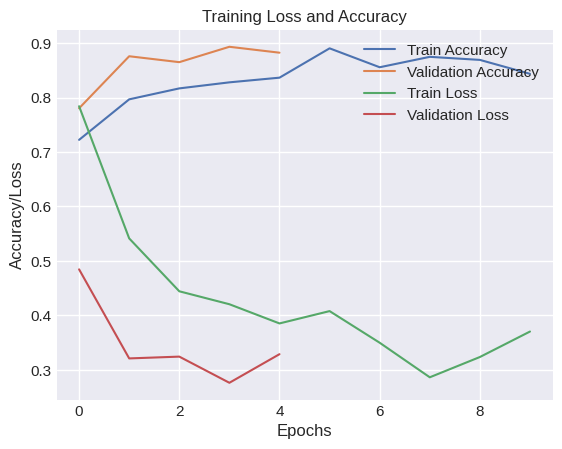

In [ ]:
# Dynamically determine training and validation epoch counts
train_epochs = np.arange(0, len(model_train.history["accuracy"]))
val_epochs = np.arange(0, len(model_train.history["val_accuracy"]))

# matplotlib style
plt.style.use("seaborn-v0_8-darkgrid")

# Plotting training loss and accuracy
plt.figure()

# Train Accuracy
plt.plot(train_epochs, model_train.history["accuracy"], label="Train Accuracy")

# Validation Accuracy
plt.plot(val_epochs, model_train.history["val_accuracy"], label="Validation Accuracy")

# Train Loss
plt.plot(train_epochs, model_train.history["loss"], label="Train Loss")

# Validation Loss
plt.plot(val_epochs, model_train.history["val_loss"], label="Validation Loss")

# Setting the title
plt.title("Training Loss and Accuracy")

# Setting labels
plt.xlabel("Epochs")
plt.ylabel("Accuracy/Loss")
plt.legend(loc="upper right")

# Saving the figure
plt.savefig("Car_Detection.png")


In [ ]:
!pip install seaborn
import matplotlib.pyplot as plt
print(plt.style.available)


['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']
